<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Fast_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fast R-CNN**

논문 링크: https://arxiv.org/abs/1504.08083

Fast R-CNN은 R-CNN의 한계점인 RoI(Region of Interest)마다 CNN 연산을 하기 때문에 학습 속도가 매우 느린점과 multi-stage pipelines이기 때문에 한번에 학습이 안된다는 점을 RoI pooling를 활용하여 속도 개선뿐만 아니라 CNN feature 추출로부터 classification, bounding box regression까지 하나의 모델로 학습하는 것으로 극복하였다.

## **Fast R-CNN 구조**

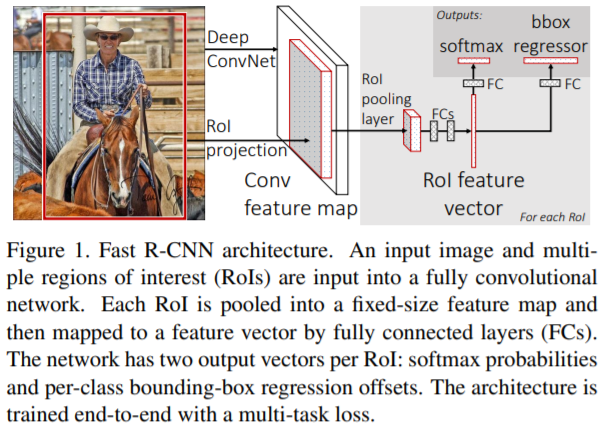

위의 그림 Figure 1을 보면 Fast R-CNN의 실행 프로세스를 알 수 있다. 먼저 R-CNN과 마찬가지로 **Selective Search**를 통해 RoI를 찾는다. 그 다음 전체 image를 CNN에 통과시켜 feature map을 추출한다. 아까 찾았던 RoI를 feature map 크기에 맞추어 projection을 시키고, projection시킨 RoI에 대해 RoI Pooling을 진행하여 고정된 크기의 feature vector를 구한다. 이렇게 구한 feature vector를 FC layer에 통과시켜 하나는 softmax를 통해 RoI에 대해 object classification을 하며, 다른 하나는 bounding box regression을 통하여 selective search로 찾은 box의 위치를 조정한다.

### **Spatial Pyramid Pooling**

이때 속도 개선과 end-to-end training을 위한 Fast R-CNN의 핵심 아이디어는 RoI Pooling이다.

기존 R-CNN에서는 CNN output이 FC layer의 input으로 넣기 위해 CNN input을 동일 size로 맞춰줘야만 했다. 따라서 원래 iamge에서 추출한 RoI를 crop, warp을 통해 동일 size로 조정하였다.

하지만 **FC layer의 input은 고정이 맞지만, Convolution layer의 input은 고정이 아니다.**(UNet 등의 model에 input size가 달라도 상관이 없는 이유다.) 즉, CNN은 input image의 size나 비율 관계없이 input으로 들어갈 수 있으며, FC layer에 input으로 넣어줄때만 size를 조정하면 되는 것이다. 이를 위해 제안된 것이 바로 **Spatial Pyramid Pooling(SPP)**이다.

SPP는 먼저 image를 CNN에 통과시켜 feature map을 추출하고 미리 정해둔 4x4, 2x2, 1x1 region의 pyramid로 feature map을 나눠준다. 그리고 이때 pyramid 한칸을 bin이라고 한다. (본 논문에서는 위와 같이 3개의 resolution으로 학습하게 되면 overfitting 문제가 일어날 수 있기 때문에 **7x7 spatial bin을 사용**했다.)

bin 내에서 각 bin마다 max pooling을 적용하여 값을 각각 추출하고 최종적인 pyramid 크기만큼 max값을 추출하여 3개의 pyramid의 결과를 쭉 이어붙여 고정된 size의 vector를 만든다.

정리하자면, **CNN을 통과한 feature map에서 2천개의 region proposal을 만들고 region proposal마다 SPPNet에 집어넣어 고정된 크기의 feature vector를 얻어냄으로써 기존 R-CNN의 2천개의 region proposal마다 해야했던 2천번의 CNN 연산을 1번으로 줄인 것**이다.

이렇게 Fast R-CNN에서 1개의 pyramid SPP로 고정된 size의 feature vector를 만드는 것을 **RoI Pooling**이라고 한다.

뿐만아니라 기존 R-CNN의 두번째 문제였던 multi-stage pipeline으로 3가지의 model 즉, CNN, SVM(classification), bounding box regression(localization)을 따로 학습해야했던 문제를 해결하였는데, 위에서 봤었던 그림 FIgure 1을 보면 알 수 있듯이 RoI Pooling으로 인하여 RoI 영역을 CNN에 거친 뒤 feature map에 투영시켜 동일 data가 softmax, bbox regression에 들어가 연산을 공유할 수 있게 되었다.

### **Loss function**

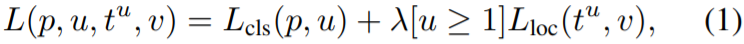

위의 식은 최종적인 loss function이다.

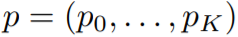

p는 softmax를 통하여 얻어낸 K+1(= K개의 object + 1개의 배경)개의 확률이다. 그리고 u는 해당 RoI의 ground truth label이다.

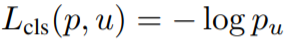

위의 식으로 p와 u를 가지고 log loss를 사용하여 classification loss를 구한다.

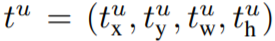

그 다음 bounding box regression을 적용하여 K+1개의 class에 대해 각각 x, y, w, h 값을 조정하는 t_K를 return한다. loss function에서는 이 값들 중 ground truth label에 해당하는 값들만 가져오며, 이는 t^u에 해당한다. v는 ground truth bounding box 조절 값에 해당한다.

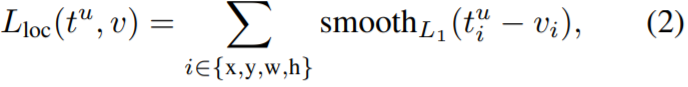

위의 식으로 bounding box regression loss를 구한다.

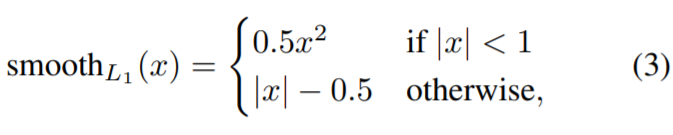

이때 smooth_L1은 위의 식과 같은데, output 값과 label의 차가 1보다 작으면 0.5x^2로 L2 distance를 계산한다. 반대로 차가 1보다 클 경우는 L1 distance를 계산해준다. 이렇게 두 가지로 object detection task에 맞추어 loss function을 custom한 이유는 본 논문의 저자들의 실험 때문이다. 실험 과정에서 label값과 지나치게 차이가 많이나는 outlier output값이 발생했고, 이를 그대로 L2 distance로 계산하여 적용할 경우 gradient explode 문제가 생겼기 때문에 이를 방지하기 위해 위와 같은 loss function을 추가한 것이다.

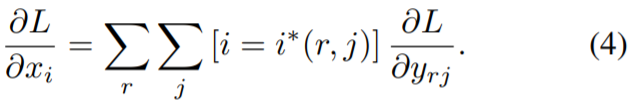

backpropagation은 위의 식과 같이 진행이 된다. 이때 x_i는 CNN을 통해 추출된 feature map에서 하나의 feature 값을 의미한다. 전체 loss에 대해서 이 feature 값의 편미분을 구하면 그 값이 곧 x_i에 대한 loss 값이 되므로 backpropagation을 진행할 수 있다.

feature map에서 RoI를 찾고 RoI Pooling을 적용하기 위해 H x W 크기로 grid를 나눈다. 이때 이 grid를 sub-window라고 부른다. 위의 식에서 j는 몇번째 sub-window인지 알려주는 index이다. y_rj란 이 RoI Pooling을 통과해 최종적으로 얻어진 output 값이다.

x_i가 최종적인 prediction 값에 영향을 주기 위해선 x_i가 속한 모든 RoI의 sub-window에서 해당 x_i가 최대값이 되면 된다. 위의 식에서 i*(r, j)란 RoI와 sub-window index j가 주어졌을때 최대 feature 값의 index를 의미하며, 이는 곧 RoI Pooling을 통과하는 index가 된다. RoI Pooling을 통과한 이후 값에 대한 loss의 경우는 이미 전체 loss에 대한 y_rj의 편미분값으로 계산이 되어있기 때문에 이를 중첩시키면 x_i에 대한 loss를 구할 수 있다.

## **Experiments**

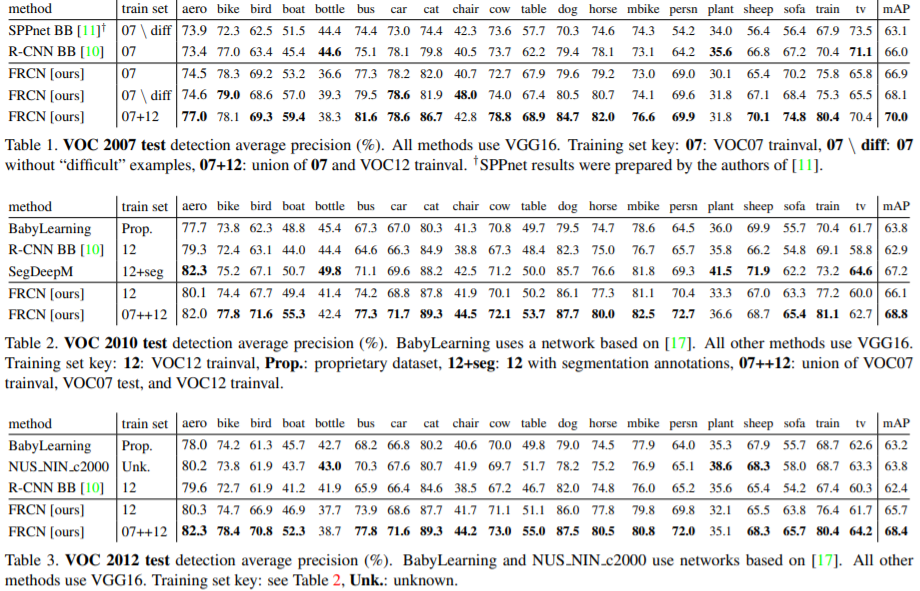

위의 표들 Table 1,2,3에서는 각각 VOC 2007, 2010, 2012 test dataset에 대해 실험을 한 결과이다. Fast R-CNN이 여러방면에서 좋은 성능을 보여주는 것을 알 수 있다.

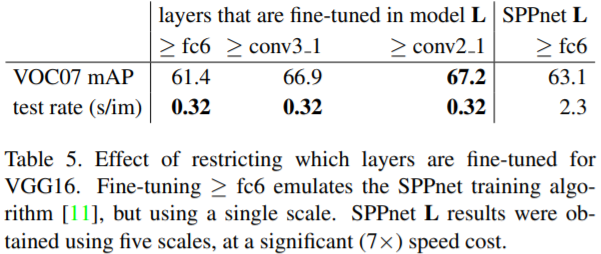

위의 표 Table 5에서는 VGG-16에 fine-tuning을 적용시킨 것이다. 위의 표에서는 conv3_1과 conv2_1에 대해 실험을 진행한 것인데, conv2_1이 조금 더 성능이 좋았지만, training 시간이 1.3배 더 소여되었기 때문에 효율을 따져봤을때, 본 논문에서는 VGG-16 기준으로 conv3_1부터 fine-tuning이 더 좋다고 언급했다.

또한, 본 논문에서는 **SVD(Singular Vector Decomposition, 특이값 분해)를 통해서 Fully Connected Layer의 parameter를 줄이는 방법**이 제안되었지만, 이후 연구에서는 사용하지 않았으므로 생략하겠다.